In [1]:
#加载全部数据到内存中
def get_data():
    from datasets import load_dataset
    import numpy as np

    #加载
    dataset = load_dataset('lansinuote/gen.1.celeba', split='train')

    #采样
    dataset = dataset.shuffle(0).select(range(2000))

    #图片转数据
    def f(data):
        images = data['image']

        data = []
        for i in images:
            i = i.resize((64, 64))
            i = np.array(i)
            i = (i - 127.5) / 127.5
            i = i.transpose(2, 0, 1)
            data.append(i)
        return {'image': data}

    dataset = dataset.map(function=f,
                          batched=True,
                          batch_size=1000,
                          num_proc=4,
                          remove_columns=list(dataset.features)[1:])

    #加载为numpy数据
    data = np.empty((2000, 3, 64, 64), dtype=np.float32)
    for i in range(len(dataset)):
        data[i] = dataset[i]['image']

    return data


data = get_data()

data.shape, data.min(), data.max()

Using custom data configuration lansinuote--gen.1.celeba-cdea5a503bf57939
Found cached dataset parquet (/root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-5eb78bab229fe5c7.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-03f004c5291f580c.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-e4d1bc770bb4c72e.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-f3c2638206a5e78a.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-819c8d4ea96c983d.arrow


((2000, 3, 64, 64), -1.0, 1.0)

In [2]:
import torch

loader = torch.utils.data.DataLoader(
    dataset=data,
    batch_size=64,
    shuffle=True,
    drop_last=True,
)

len(loader), next(iter(loader)).shape

(31, torch.Size([64, 3, 64, 64]))

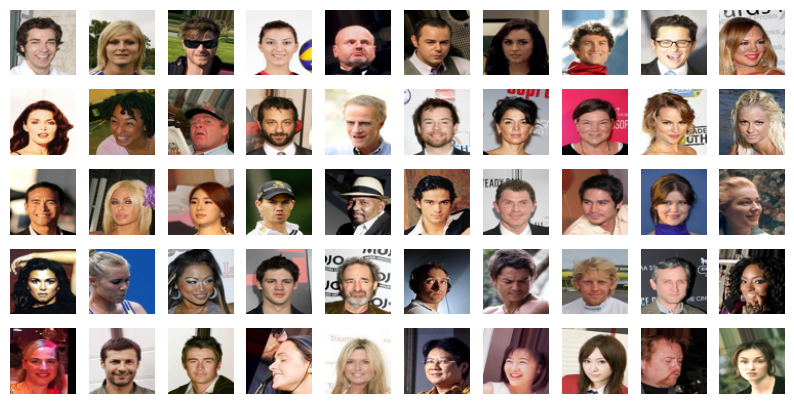

In [3]:
def show(images):
    from matplotlib import pyplot as plt

    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()

    images = images[:50]

    plt.figure(figsize=(10, 5))

    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)
        image = (image + 1) / 2

        plt.subplot(5, 10, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


show(next(iter(loader)))

In [4]:
import torchvision

#使用预训练的模型作为encoder,并且不再训练它的参数
encoder = torchvision.models.regnet_y_800mf(weights='IMAGENET1K_V2')

encoder.fc = torch.nn.BatchNorm1d(num_features=784)

encoder(torch.randn(2, 3, 64, 64)).shape

torch.Size([2, 784])

In [5]:
def block(in_channels,
          out_channels,
          kernel_size=5,
          stride=2,
          padding=1,
          dropout=True):

    sequential = [
        torch.nn.Conv2d(in_channels=in_channels,
                        out_channels=in_channels,
                        kernel_size=3,
                        stride=1,
                        padding=1),
        torch.nn.LeakyReLU(),
        torch.nn.ConvTranspose2d(in_channels=in_channels,
                                 out_channels=out_channels,
                                 kernel_size=kernel_size,
                                 stride=stride,
                                 padding=padding),
        torch.nn.BatchNorm2d(num_features=out_channels),
        torch.nn.LeakyReLU(),
    ]

    if dropout:
        sequential.append(torch.nn.Dropout(p=0.2))

    return torch.nn.Sequential(*sequential)


decoder = torch.nn.Sequential(
    torch.nn.Linear(in_features=784, out_features=512 * 4 * 4),
    torch.nn.BatchNorm1d(num_features=512 * 4 * 4),
    torch.nn.Unflatten(dim=1, unflattened_size=(512, 4, 4)),
    block(512, 256),
    block(256, 128),
    block(128, 64),
    block(64, 3, dropout=False),
    torch.nn.UpsamplingNearest2d(size=64),
    torch.nn.Conv2d(in_channels=3,
                    out_channels=3,
                    kernel_size=1,
                    stride=1,
                    padding=0),
    torch.nn.Tanh(),
)

decoder(torch.randn(2, 784)).shape

torch.Size([2, 3, 64, 64])

In [6]:
optimizer = torch.optim.Adam(decoder.parameters(), lr=2e-4)
criterion = torch.nn.MSELoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder.to(device)
decoder.to(device)

encoder.eval()
for param in encoder.parameters():
    param.requires_grad_(False)

decoder.train()

device

'cuda'

0 0.4002397954463959


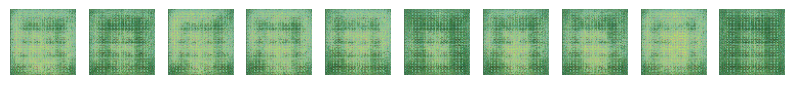

50 0.04692591726779938


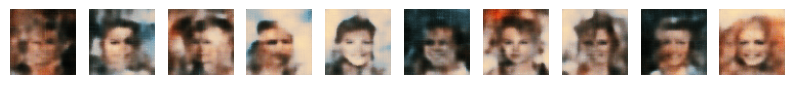

100 0.025419320911169052


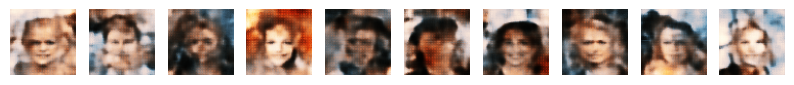

150 0.02154972404241562


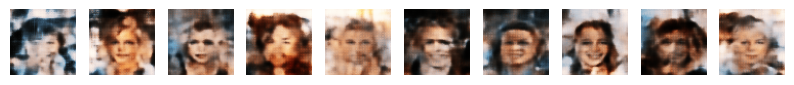

200 0.020224448293447495


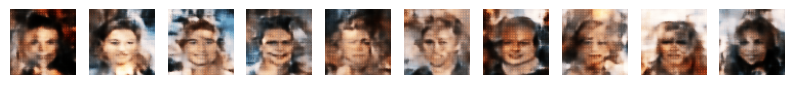

250 0.015100091695785522


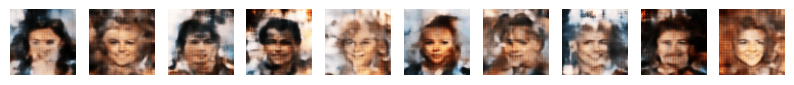

300 0.013883466832339764


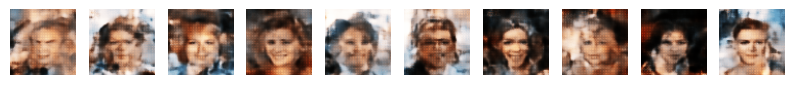

350 0.01550624705851078


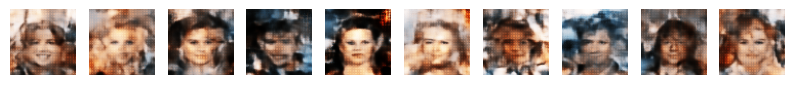

400 0.011875146999955177


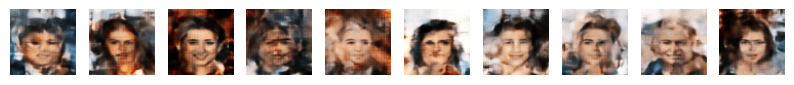

450 0.013804396614432335


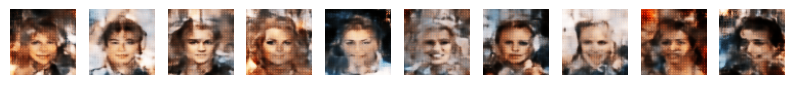

500 0.011948115192353725


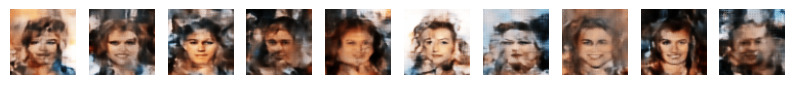

550 0.01402436476200819


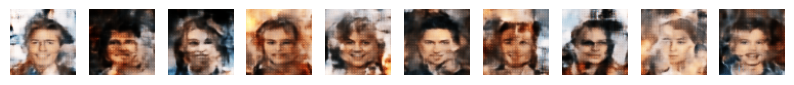

600 0.011338964104652405


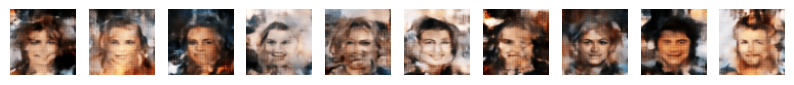

650 0.011600708588957787


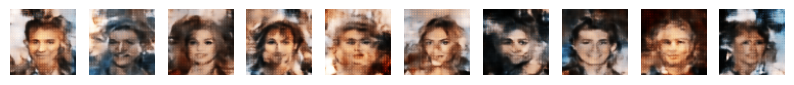

700 0.01011093519628048


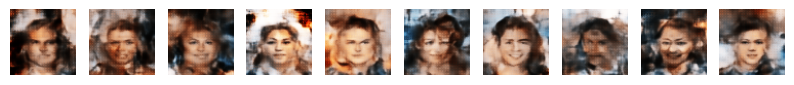

750 0.011118516325950623


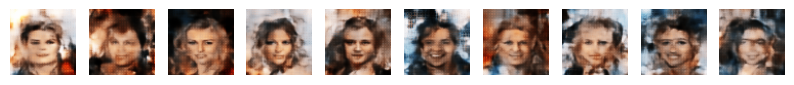

800 0.010813969187438488


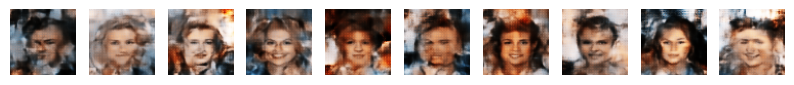

850 0.011073361150920391


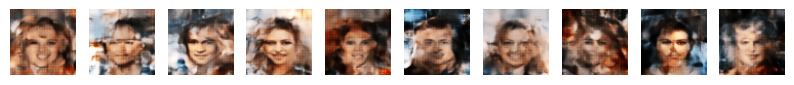

900 0.009372536092996597


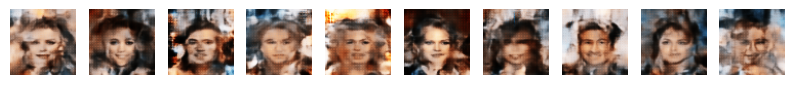

950 0.010703636333346367


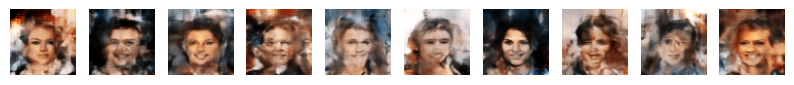

In [7]:
def train():
    for epoch in range(1000):
        for _, data in enumerate(loader):
            data = data.to(device)

            with torch.no_grad():
                #[b, 3, 64, 64] -> [b, 784]
                hidden = encoder(data)

            #[b, 784] -> [b, 3, 64, 64]
            pred = decoder(hidden)
            loss = criterion(pred, data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 50 == 0:
            print(epoch, loss.item())

            with torch.no_grad():
                gen = decoder(torch.randn(10, 784, device=device))
            show(gen)


local_training = True

if local_training:
    train()

In [8]:
from transformers import PreTrainedModel, PretrainedConfig


class Model(PreTrainedModel):
    config_class = PretrainedConfig

    def __init__(self, config):
        super().__init__(config)
        self.decoder = decoder.to('cpu')


if local_training:
    #保存训练好的模型到hub
    Model(PretrainedConfig()).push_to_hub(
        repo_id='lansinuote/gen.1.ae',
        use_auth_token=open('/root/hub_token.txt').read().strip())

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/55.6M [00:00<?, ?B/s]

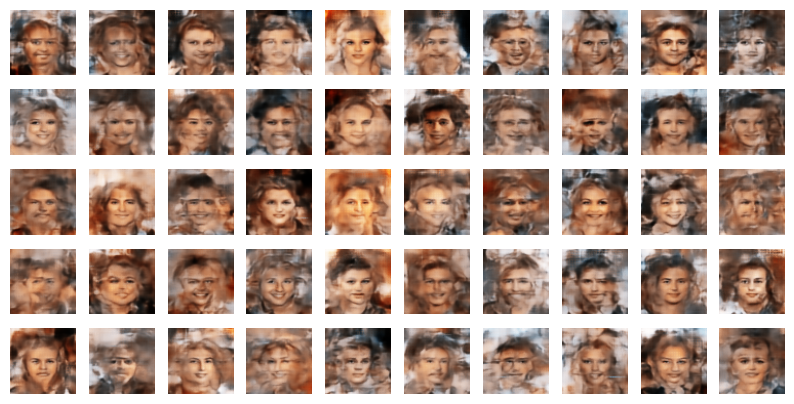

In [9]:
#加载训练好的模型
decoder = Model.from_pretrained('lansinuote/gen.1.ae').decoder

with torch.no_grad():
    gen = decoder(torch.randn(50, 784))
    
show(gen)